In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Importing required libraries

In [2]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

## Data path

In [3]:
csv = 'features.csv'
Features = pd.read_csv(csv)

## Looking into the data

In [4]:
Features.shape

(4320, 21)

In [5]:
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-637.701233,104.299019,4.894947,20.494011,12.552954,2.851410,-6.633390,-4.091278,-10.423918,-6.406950,...,0.172893,-1.170210,-5.292450,-0.573319,1.019471,-3.492607,-3.468123,-1.214944,1.971239,male_calm
1,-596.908460,86.871936,9.470162,17.109819,11.198966,1.541056,-6.677264,-5.755428,-9.684472,-6.891256,...,0.033803,-1.986515,-5.103855,-1.253110,0.514896,-3.268317,-4.502895,0.167153,0.256732,male_calm
2,-698.086548,99.795929,1.892679,19.915264,7.532868,1.265761,-9.188656,-5.798194,-12.299710,-4.976400,...,-1.639542,-2.603761,-4.890347,-0.879222,-1.250208,-3.449960,-4.708529,-0.086224,-3.034044,male_calm
3,-279.141052,41.092949,-21.319229,7.802911,-13.140503,-9.407660,-15.580647,-6.097223,-24.700903,-9.640293,...,-10.305976,-4.092835,-5.817179,-10.731523,-0.823596,-15.885103,-2.014258,-6.173852,-5.331760,male_angry
4,-160.074686,17.576058,-2.147436,3.133417,-4.745002,-6.510771,-5.911591,-4.481506,-9.470598,-5.907823,...,-4.088007,-1.817639,-2.994765,-4.893176,-2.880436,-7.163400,-2.147345,-2.359248,-3.746217,male_angry


**0 - 19 columns are the extracted features and can be trained to get the desired emotion.**

## One Hot Encoding and Scaling the data

In [6]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=24, shuffle=True)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20, 1), (3240, 16), (1080, 20, 1), (1080, 16))

## Model building

In [7]:
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='softmax'))

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 20, 2048)            │          12,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 10, 2048)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 2048)            │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 10, 1024)            │      10,486,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 5, 1024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 5, 1024)             │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 5, 512)              │       2,621,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 3, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 3, 512)              │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 3, 256)              │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,147,312 (53.97 MB)

 Trainable params: 14,140,144 (53.94 MB)

 Non-trainable params: 7,168 (28.00 KB)

## Callback

In [53]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 82s 728ms/step - accuracy: 0.0772 - loss: 2.7577 - val_accuracy: 0.0935 - val_loss: 2.7655 - learning_rate: 1.0000e-04
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 84s 744ms/step - accuracy: 0.1107 - loss: 2.7075 - val_accuracy: 0.0824 - val_loss: 2.7554 - learning_rate: 1.0000e-04
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 79s 772ms/step - accuracy: 0.1447 - loss: 2.6457 - val_accuracy: 0.1278 - val_loss: 2.7333 - learning_rate: 1.0000e-04
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 98s 917ms/step - accuracy: 0.1634 - loss: 2.5827 - val_accuracy: 0.1704 - val_loss: 2.6619 - learning_rate: 1.0000e-04
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 80s 784ms/step - accuracy: 0.1726 - loss: 2.5032 - val_accuracy: 0.2093 - val_loss: 2.5028 - learning_rate: 1.0000e-04
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 77s 754ms/step - accuracy: 0.1919 - loss: 2.3830 - val_accuracy: 0.2657 - val_loss: 2.3046 - learning_rate: 1.0000e-04
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━

In [54]:
print("Accuracy of our model on test data : " , model.evaluate(x_test, y_test)[1]*100 , "%")

34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.8346 - loss: 0.8796
Accuracy of our model on test data :  82.87037014961243 %


## Plotting train and test loss and accuracy

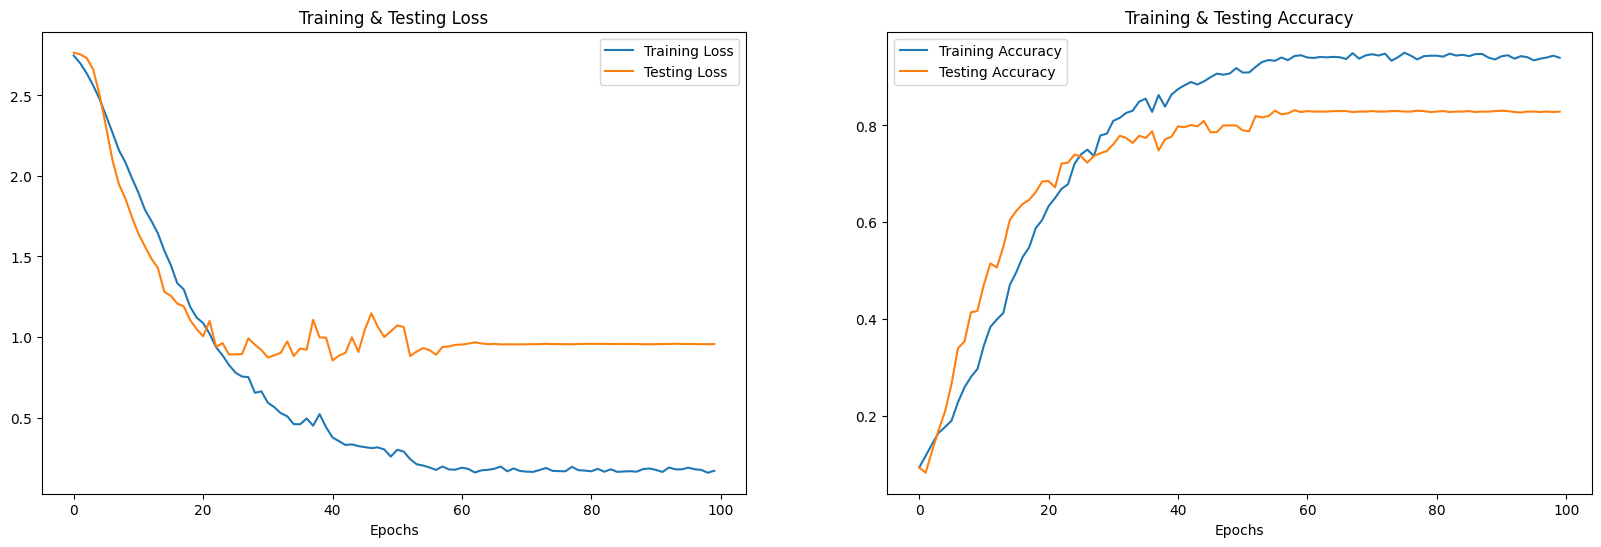

In [56]:
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [57]:
model=model = keras.models.load_model('my_model.keras')

pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step


,Predicted Labels,Actual Labels
0,female_surprise,female_fear
1,female_calm,female_calm
2,male_angry,male_fear
3,female_surprise,female_surprise
4,female_disgust,female_happy
5,male_disgust,male_disgust
6,male_fear,male_fear
7,female_fear,female_fear
8,female_disgust,female_surprise
9,male_surprise,male_surprise


## Confusion Matrix

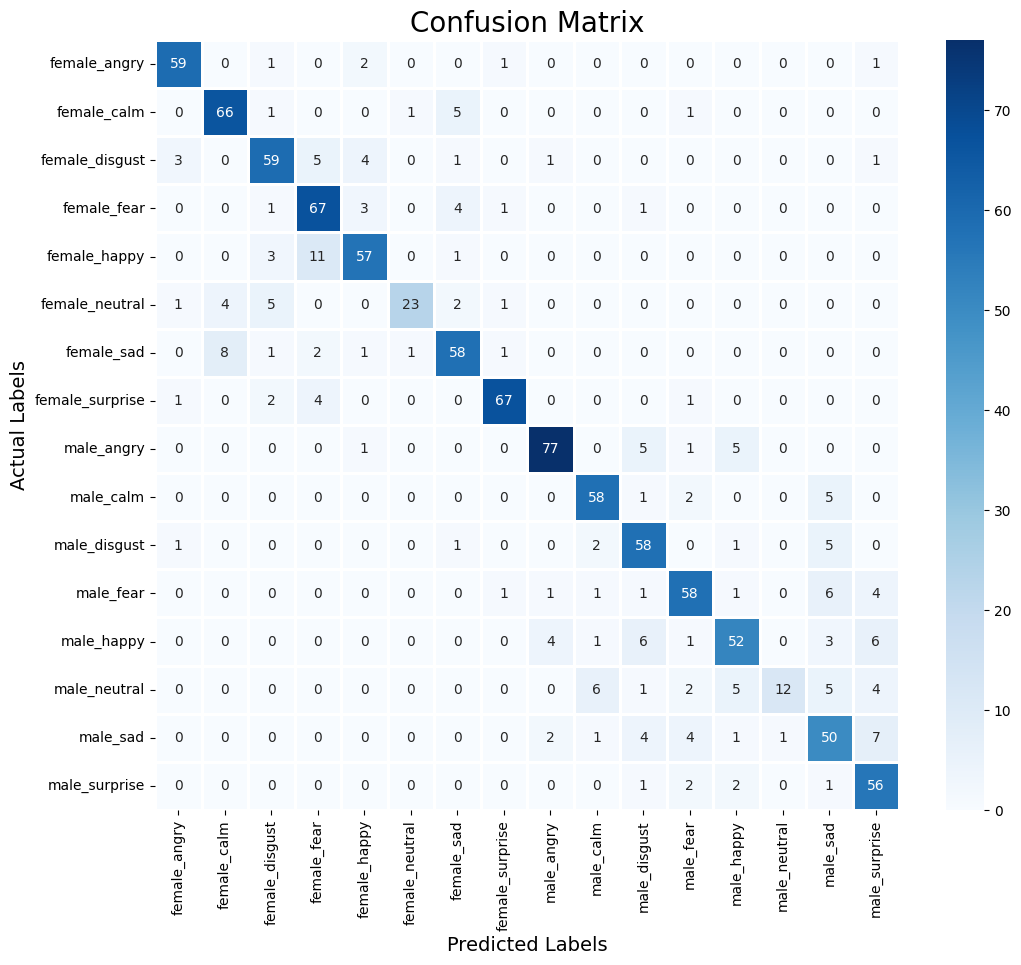

In [58]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [59]:
from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

                 precision    recall  f1-score   support

   female_angry       0.91      0.92      0.91        64
    female_calm       0.85      0.89      0.87        74
 female_disgust       0.81      0.80      0.80        74
    female_fear       0.75      0.87      0.81        77
   female_happy       0.84      0.79      0.81        72
 female_neutral       0.92      0.64      0.75        36
     female_sad       0.81      0.81      0.81        72
female_surprise       0.93      0.89      0.91        75
     male_angry       0.91      0.87      0.89        89
      male_calm       0.84      0.88      0.86        66
   male_disgust       0.74      0.85      0.79        68
      male_fear       0.81      0.79      0.80        73
     male_happy       0.78      0.71      0.74        73
   male_neutral       0.92      0.34      0.50        35
       male_sad       0.67      0.71      0.69        70
  male_surprise       0.71      0.90      0.79        62

       accuracy              

In [62]:
model.save('my_model.keras')